In [4]:
import numpy as np
import pandas as pd

import os

import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import keras

from scipy.stats import zscore

from datetime import datetime

In [5]:
path = r"\Users\mahin\Downloads\Collected_data"

scenarios = []
data_files = []

# List subfolders in the "Collected_data" folder and populate the "scenarios" list
for folder in os.listdir(path):
    folder_path = os.path.join(path, folder)
    if os.path.isdir(folder_path):
        scenarios.append(folder)

In [6]:
# Load data from each scenario and concatenate
for scenario in scenarios:
    scenario_data = []
    file = 0
    for file_name in os.listdir(os.path.join(path, scenario)):
        file_path = os.path.join(path, scenario, file_name)
        if file_name.endswith('.csv'):
            file_data = pd.read_csv(file_path)
            scenario_data.append(file_data[['systemTime', 'currentLinkStatus', 'multiPointRelaySelector', 'lossTime','linkQuality', 'neighborLinkQuality1','linkCost', 'RSSI value', 'AVG RSSI value', 'trend','tau',
                                            'Connected']])
    scenario_data = pd.concat(scenario_data, ignore_index=True)
    data_files.append(scenario_data)
for f in data_files:
    f['currentLinkStatus'] = f['currentLinkStatus'].astype('category').cat.codes
    f['multiPointRelaySelector'] = f['multiPointRelaySelector'].astype('category').cat.codes


In [19]:
# Encoding lables for currentLinkStatus
# LOST = 1
# ASYMMETRIC = 0
# SYMMETRIC = 2

In [6]:
combined_df = pd.concat(data_files)
print('Total no. of entries:',combined_df.shape[0],'Connection entries:',np.sum(combined_df['Connected']==1), 'Disconnection entries:', np.sum(combined_df['Connected']==0))

Total no. of entries: 6834 Connection entries: 5751 Disconnection entries: 409


<Figure size 1000x800 with 0 Axes>

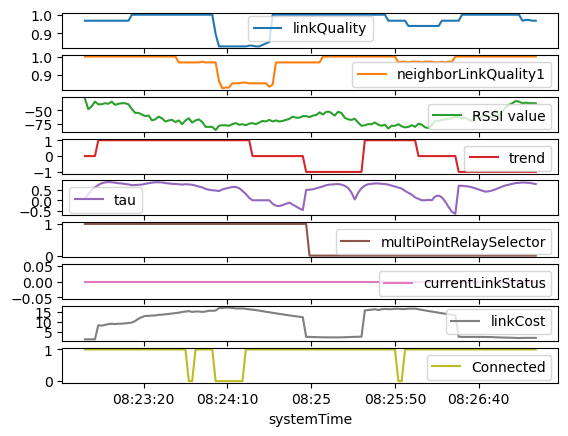

In [71]:
plt.figure(figsize=(10, 8))

# Create a copy of the DataFrame of the third scenario
data_copy = data_files[4].copy()

# Convert 'systemTime' to datetime and then to time
data_copy['systemTime'] = pd.to_datetime(data_copy['systemTime'], unit='s')
data_copy['systemTime'] = data_copy['systemTime'].dt.time


# Plot the data
data_copy.set_index('systemTime')[['linkQuality', 'neighborLinkQuality1', 'RSSI value', 'trend','tau',
                                    'multiPointRelaySelector','currentLinkStatus', 'linkCost',
                                    'Connected']].plot(subplots=True)

# Show the plot
plt.show()

Creating a combined_df with all relevant features to plot correlations heatmap

In [15]:
files=[]
for scenario in scenarios:
    scenario_data = []
    file = 0
    for file_name in os.listdir(os.path.join(path, scenario)):
        file_path = os.path.join(path, scenario, file_name)
        if file_name.endswith('.csv'):
            file_data = pd.read_csv(file_path)
            scenario_data.append(file_data[['systemTime','isMultiPointRelay','wasMultiPointRelay','multiPointRelaySelector','currentLinkStatus','linkCost','linkQuality','neighborLinkQuality1','RSSI value','AVG RSSI value','trend','tau',
                                            'Connected']])
    scenario_data = pd.concat(scenario_data, ignore_index=True)
    files.append(scenario_data)

for df in files:
    df['currentLinkStatus'] = df['currentLinkStatus'].astype('category').cat.codes
    df['multiPointRelaySelector'] = df['multiPointRelaySelector'].astype('category').cat.codes
    df['isMultiPointRelay'] = df['isMultiPointRelay'].astype('category').cat.codes
    df['wasMultiPointRelay'] = df['wasMultiPointRelay'].astype('category').cat.codes


combined_df = pd.concat(files).drop(columns=['Connected'])
correlation_matrix = combined_df.corr()
    

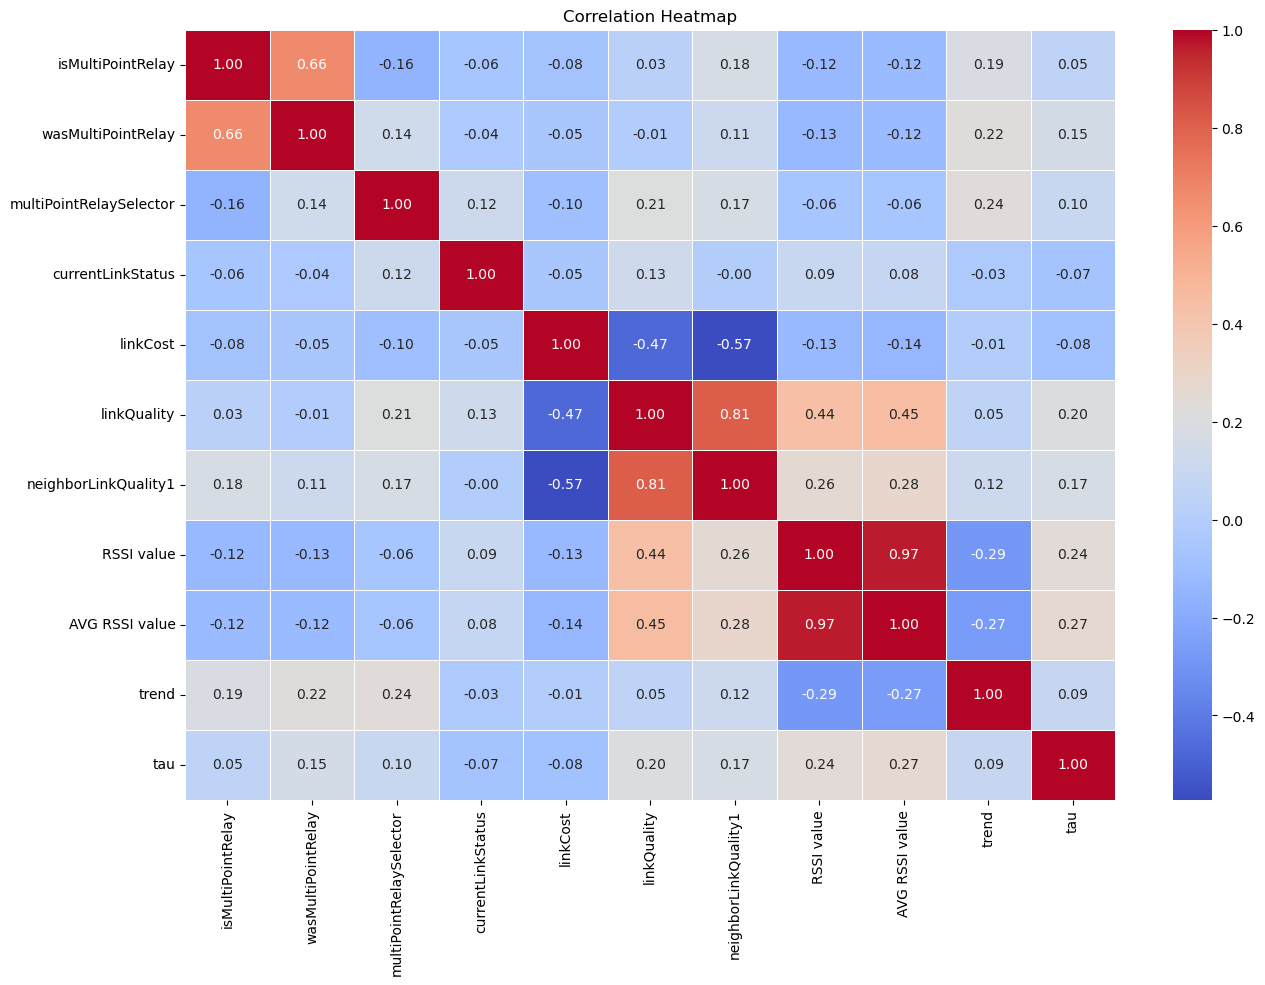

In [46]:
# Create a heatmap using seaborn
plt.figure(figsize=(15,10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

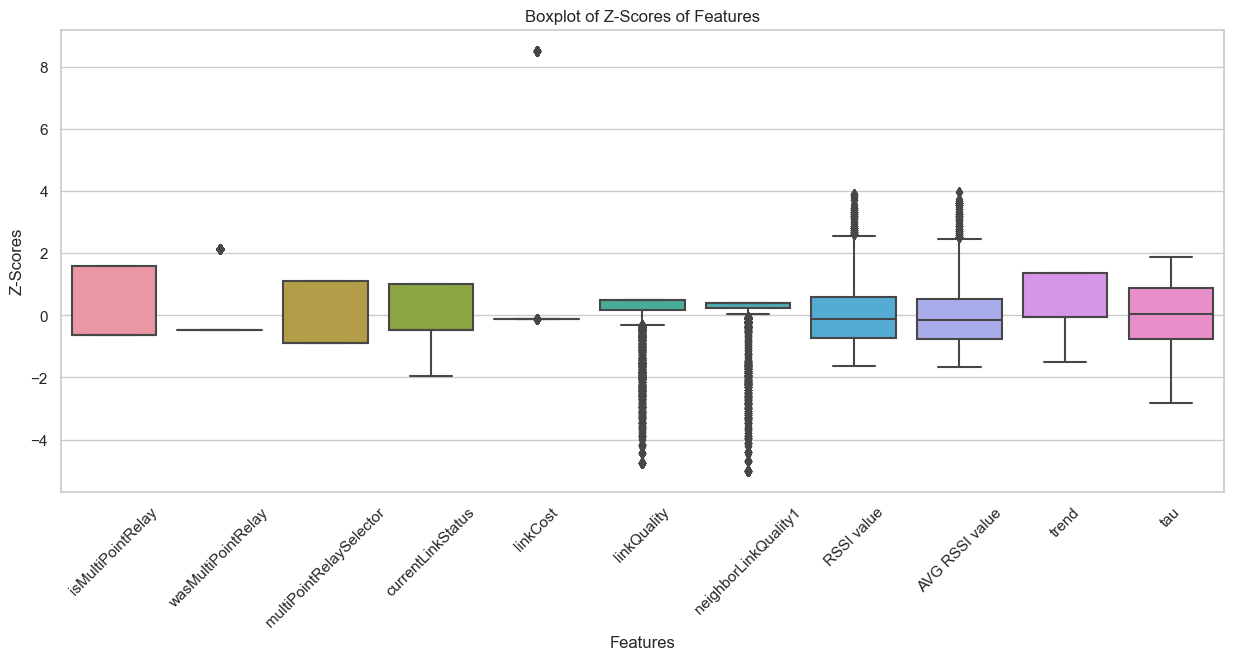

In [60]:
combined_df_zscore = combined_df.apply(zscore)
# Plot boxplots for each feature
plt.figure(figsize=(15, 6))  # Adjust size as needed
sns.boxplot(data=combined_df_zscore)  # Use z-scores for boxplot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.title("Boxplot of Z-Scores of Features")
plt.xlabel("Features")
plt.ylabel("Z-Scores")
plt.show()

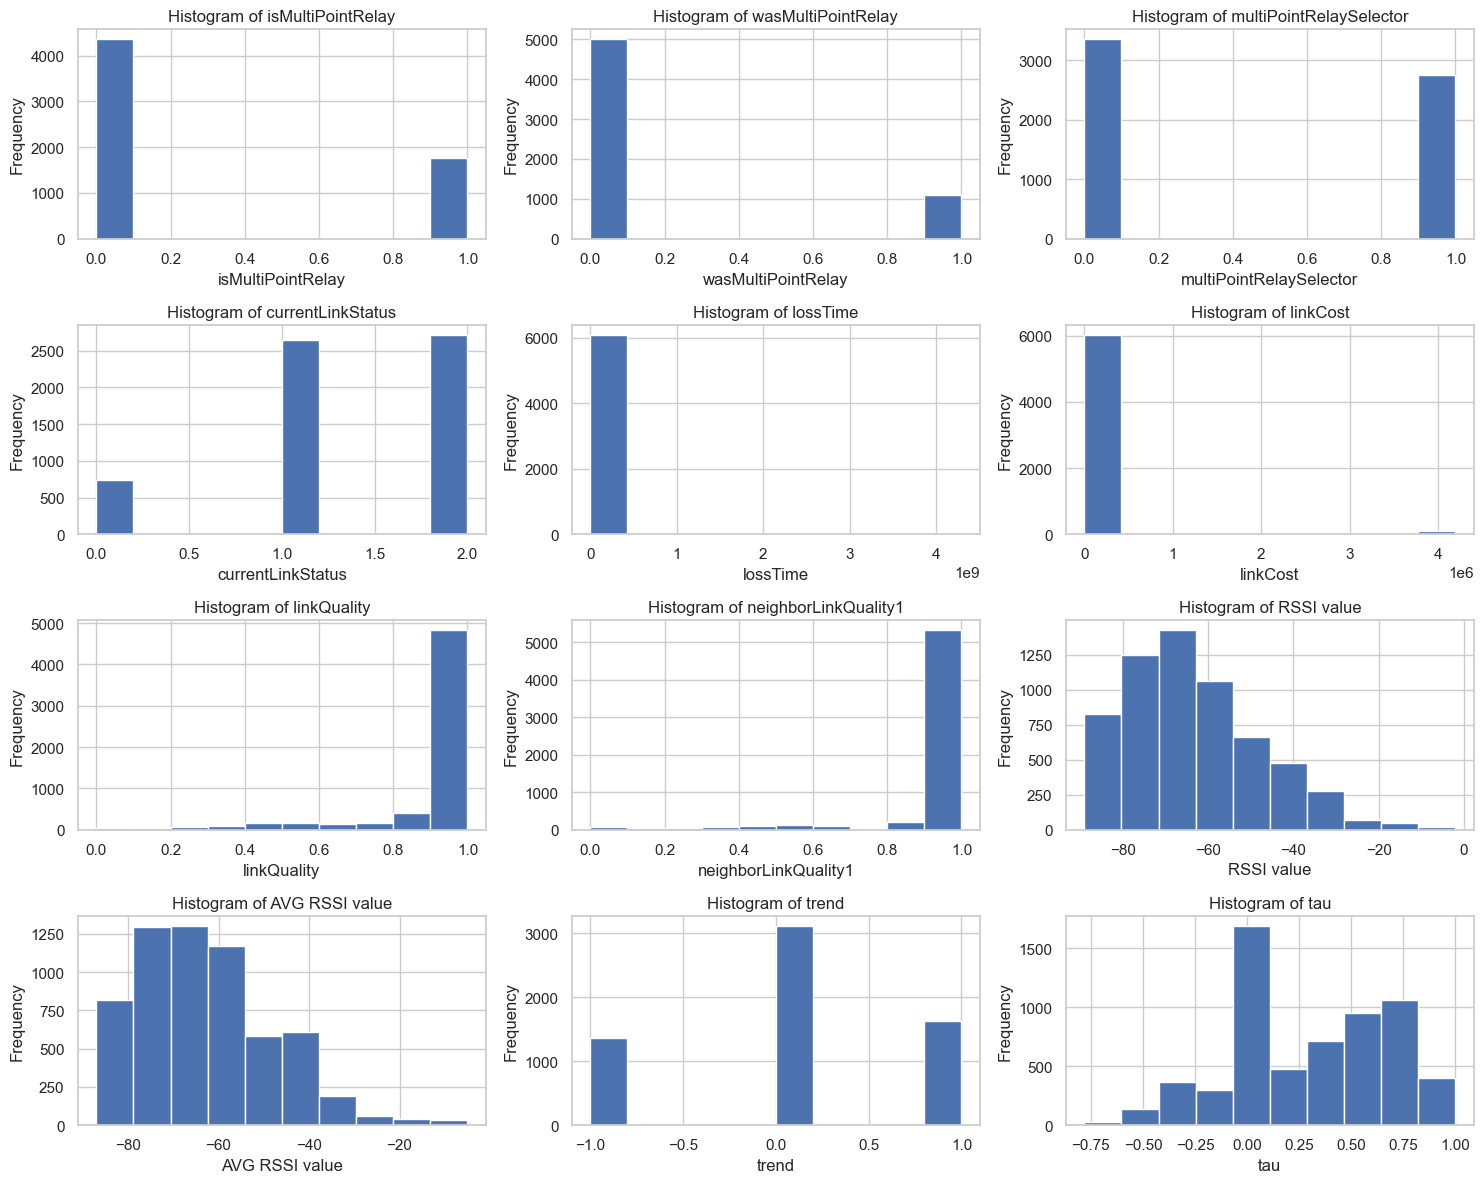

In [50]:
num_rows = 4
num_cols = 3
num_features = len(combined_df.columns)

# Create a figure and axes for the subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 12))  
axs = axs.flatten()

# Iterate through each feature and create a histogram for each
for i, column in enumerate(combined_df.columns):
    ax = axs[i]
    combined_df[column].hist(ax=ax)
    ax.set_title(f"Histogram of {column}")
    ax.set_xlabel(column)
    ax.set_ylabel("Frequency")

# Adjust layout
plt.tight_layout()
plt.show()


In [41]:
if(combined_df.isnull().any(axis=1).sum()>0):
    print('missing values')

In [14]:
combined_df['Connected'].unique()

array([1. , 0.8, 0.6, 0.4, 0.2, 0. , 0.2])

Explained Variance Ratio: [0.27125202 0.19350595 0.12938367 0.10187003 0.09312463]


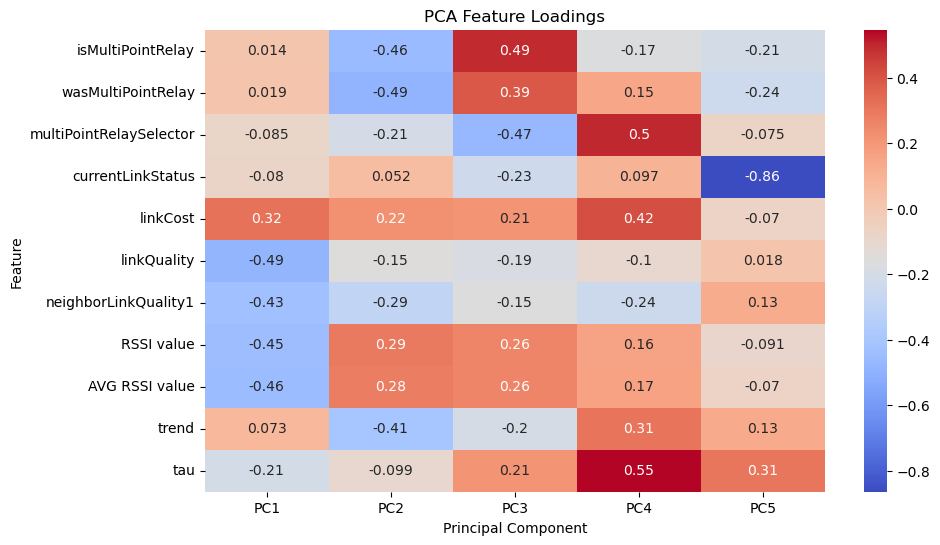

In [22]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(combined_df.drop(columns=['systemTime']))
pca = PCA(n_components=5)  # Choose the number of components
principal_components = pca.fit_transform(X_scaled)
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance_ratio)
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2','PC3','PC4','PC5'])
loading_matrix = pca.components_.T  # Transpose to get features as rows
feature_names = ['isMultiPointRelay','wasMultiPointRelay','multiPointRelaySelector','currentLinkStatus','linkCost','linkQuality','neighborLinkQuality1','RSSI value','AVG RSSI value','trend','tau']
loading_df = pd.DataFrame(data=loading_matrix, columns=['PC1', 'PC2','PC3','PC4', 'PC5'], index=feature_names)
plt.figure(figsize=(10, 6))
sns.heatmap(loading_df, annot=True, cmap='coolwarm')
plt.title('PCA Feature Loadings')
plt.xlabel('Principal Component')
plt.ylabel('Feature')
plt.show()

In [20]:
cumulative_variance_explained = np.sum(explained_variance_ratio)
cumulative_variance_explained

0.46475797122639595

Preparing the dataset

In [7]:
Tx = 20
offset = 3
stride = 1
feature = []
label = []

for scenario_data in data_files:
    j = 0
    scenario_data['Connected'] = scenario_data['Connected'].apply(lambda x: 0 if x <= 0.75 else 1)
    last_label = scenario_data['Connected'].iloc[-1]  # Get the last label of the scenario

    while j + Tx <= scenario_data.shape[0] - offset:
        feature.append(scenario_data[['linkQuality', 'neighborLinkQuality1', 'RSSI value', 'trend', 'tau']].iloc[j:j + Tx].values)
        current_label_idx = j + Tx + offset - 1  # Adjust the index calculation

        if current_label_idx < scenario_data.shape[0]:
            label.append(scenario_data['Connected'].iloc[current_label_idx])
        else:
            label.append(last_label)  # Use the last label if out of bounds

        j += stride

X = np.array(feature)
Y = np.array(label)

In [18]:
# using unbalanced data
trainX, testX, trainy, testy = train_test_split(X, Y, train_size=0.8, random_state=101)

Doing exhaustive model training using differnt combinations of features to determine feature relevance (the folloeing two code block may take over an hour)

In [8]:
import itertools

# List of features
items = ['multiPointRelaySelector','currentLinkStatus', 'linkQuality', 'neighborLinkQuality1', 'RSSI value', 'trend', 'tau']

# Find all possible combinations
all_combinations = []
for r in range(1, len(items) + 1):
    combinations = list(itertools.combinations(items, r))
    all_combinations.extend(combinations)

feature_list = []
# Print all combinations
for combination in all_combinations:
    feature_list.append(list(combination))


In [ ]:
Tx = 20
offset = 3
stride = 1
feature = []
label = []

cols = ['multiPointRelaySelector','currentLinkStatus','linkQuality', 'neighborLinkQuality1', 'RSSI value', 'trend', 'tau']

# Prepare data
feature = []
label = []
for scenario_data in data_files:
    scenario_data['Connected'] = scenario_data['Connected'].apply(lambda x: 0 if x < 0.75 else 1)
    last_label = scenario_data['Connected'].iloc[-1]  # Get the last label of the scenario

    for j in range(len(scenario_data) - Tx - offset):
        feature.append(scenario_data[cols].iloc[j:j + Tx].values)
        current_label_idx = j + Tx + offset - 1  # Adjust the index calculation

        if current_label_idx < len(scenario_data):
            label.append(scenario_data['Connected'].iloc[current_label_idx])
        else:
            label.append(last_label)  # Use the last label if out of bounds


# Initialize a dictionary to store results
results = []

# Iterate through different subsets of features
for subset in feature_list:

    print("Testing subset:", subset)
    
    # Extract subset of features
    subset_indices = [cols.index(col) for col in subset]
    X = np.array([x[:, subset_indices] for x in feature])

    Y = np.array(label)

    trainX, testX, trainy, testy = train_test_split(X, Y, train_size=0.8, random_state=101)

    model = Sequential()
    model.add(LSTM(32))
    model.add(Dense(1, activation='sigmoid'))
    opt = Adam(learning_rate=0.001) 
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

    
    # Train the model
    model.fit(trainX, trainy, epochs=45, batch_size=64)

    # Evaluate model performance
    loss, accuracy = model.evaluate(testX, testy, verbose=0)
    
    # Store results
    results.append({'subset': subset, 'loss': loss, 'accuracy': accuracy})


In [ ]:
# Print results
for performance in results:
    print(f"Features: {performance['subset']}, Loss: {performance['loss']:.3f}, Accuracy: {performance['accuracy']:.3f}")


In [14]:
results_sorted_loss = sorted(results, key=lambda x: x['loss'])
results_sorted = sorted(results_sorted_loss, key=lambda x: x['accuracy'], reverse=True)

print("Top 5 subsets with highest accuracy and lowest loss:")
for performance in results_sorted[:5]:
    print(f"Features: {performance['subset']}, Loss: {performance['loss']:.3g}, Accuracy: {performance['accuracy']:.3g}")


Top 5 subsets with highest accuracy and lowest loss:
Features: ['multiPointRelaySelector', 'currentLinkStatus', 'linkQuality', 'neighborLinkQuality1', 'RSSI value', 'trend'], Loss: 0.141, Accuracy: 0.956
Features: ['multiPointRelaySelector', 'currentLinkStatus', 'neighborLinkQuality1', 'RSSI value', 'trend', 'tau'], Loss: 0.147, Accuracy: 0.956
Features: ['multiPointRelaySelector', 'currentLinkStatus', 'linkQuality', 'RSSI value', 'tau'], Loss: 0.142, Accuracy: 0.955
Features: ['multiPointRelaySelector', 'currentLinkStatus', 'linkQuality', 'neighborLinkQuality1', 'RSSI value', 'tau'], Loss: 0.138, Accuracy: 0.954
Features: ['currentLinkStatus', 'neighborLinkQuality1', 'RSSI value', 'tau'], Loss: 0.147, Accuracy: 0.954


In [2]:
from imblearn.over_sampling import SMOTE

In [8]:
X_2d = X.reshape(X.shape[0], -1)

# Apply SMOTE to balance the dataset
smote = SMOTE()
X_resampled, Y_resampled = smote.fit_resample(X_2d, Y)

# Reshape X for LSTM
X_lstm = X_resampled.reshape(X_resampled.shape[0], Tx, -1)

In [9]:
# using balanced data after using SMOTE
trainX, testX, trainy, testy = train_test_split(X_lstm, Y_resampled, train_size=0.8, random_state=101)

In [10]:
def test_scenario(test_X, test_Y, model):
    predictions = model.predict(test_X)

    # Convert the predictions to binary values (0 or 1) based on a threshold (e.g., 0.5)
    threshold = 0.5
    binary_predictions = (predictions > threshold).astype(int)

    # Calculate metrics
    cm = confusion_matrix(test_Y, binary_predictions)
    acc = accuracy_score(test_Y, binary_predictions)
    precision = precision_score(test_Y, binary_predictions)
    recall = recall_score(test_Y, binary_predictions)
    f1 = f1_score(test_Y, binary_predictions)
    mcc = matthews_corrcoef(test_Y, binary_predictions)

    # Print metrics
    print("Confusion Matrix:")
    print(cm)
    
    print("Accuracy:", acc)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Matthews Correlation Coefficient:", mcc)

    report = classification_report(test_Y, binary_predictions)
    print("Classification Report:\n", report)

LSTM Model with 1D Convolutional layer
(Switch between LSTM and GRU as needed)

In [11]:
logdir="CL-LSTM-32" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
n_features = 5  # Number of features in the data

# Reshape data for Conv1D
trainX_conv = trainX.reshape((trainX.shape[0], trainX.shape[1], n_features))

# Define the model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(Tx, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(GRU(32))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
opt = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# Train the model
model.fit(trainX_conv, trainy, epochs=45, batch_size=64, verbose=2,callbacks=[tensorboard_callback])

print(model.summary())

print("Testing on test dataset: \n")
test_scenario(testX, testy, model)



Epoch 1/45


133/133 - 5s - loss: 0.4939 - accuracy: 0.8022 - 5s/epoch - 36ms/step
Epoch 2/45
133/133 - 1s - loss: 0.3825 - accuracy: 0.8409 - 751ms/epoch - 6ms/step
Epoch 3/45
133/133 - 1s - loss: 0.3491 - accuracy: 0.8531 - 701ms/epoch - 5ms/step
Epoch 4/45
133/133 - 1s - loss: 0.3295 - accuracy: 0.8638 - 668ms/epoch - 5ms/step
Epoch 5/45
133/133 - 1s - loss: 0.3401 - accuracy: 0.8568 - 670ms/epoch - 5ms/step
Epoch 6/45
133/133 - 1s - loss: 0.3126 - accuracy: 0.8699 - 648ms/epoch - 5ms/step
Epoch 7/45
133/133 - 1s - loss: 0.2988 - accuracy: 0.8781 - 670ms/epoch - 5ms/step
Epoch 8/45
133/133 - 1s - loss: 0.2859 - accuracy: 0.8808 - 639ms/epoch - 5ms/step
Epoch 9/45
133/133 - 1s - loss: 0.2772 - accuracy: 0.8860 - 688ms/epoch - 5ms/step
Epoch 10/45
133/133 - 1s - loss: 0.2803 - accuracy: 0.8838 - 683ms/epoch - 5ms/step
Epoch 11/45
133/133 - 1s - loss: 0.2763 - accuracy: 0.8868 - 642ms/epoch - 5ms/step
Epoch 12/45
133/133 - 1s - loss: 0.3073 - accuracy: 0.8754 - 699ms/epoch - 5ms/step

In [15]:
model.save("Model-01.h5")

c:\Users\mahin\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


LSTM-only model (Switch between LSTM and GRU as needed)

In [26]:
logdir="LSTM-32" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

model = Sequential()
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))

opt = Adam(learning_rate=0.001) 
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.fit(trainX, trainy, epochs=40, batch_size=64 , verbose=2,callbacks=[tensorboard_callback])

print(model.summary())

print("Testing on test dataset: \n")
test_scenario(testX, testy, model)

Epoch 1/40
75/75 [==============================] - 5s 7ms/step - loss: 0.3489 - accuracy: 0.8868
Epoch 2/40
75/75 [==============================] - 1s 7ms/step - loss: 0.2937 - accuracy: 0.8868
Epoch 3/40
75/75 [==============================] - 1s 7ms/step - loss: 0.2464 - accuracy: 0.8868
Epoch 4/40
75/75 [==============================] - 1s 7ms/step - loss: 0.2303 - accuracy: 0.8873
Epoch 5/40
75/75 [==============================] - 1s 7ms/step - loss: 0.2185 - accuracy: 0.9032
Epoch 6/40
75/75 [==============================] - 1s 7ms/step - loss: 0.2106 - accuracy: 0.9152
Epoch 7/40
75/75 [==============================] - 1s 7ms/step - loss: 0.2022 - accuracy: 0.9179
Epoch 8/40
75/75 [==============================] - 1s 7ms/step - loss: 0.1986 - accuracy: 0.9208
Epoch 9/40
75/75 [==============================] - 1s 7ms/step - loss: 0.1952 - accuracy: 0.9290
Epoch 10/40
75/75 [==============================] - 1s 7ms/step - loss: 0.1925 - accuracy: 0.9282
Epoch 11/40
75/75 [

Treating y labels as continous (regression) instead of binary classification

Epoch 1/45
75/75 - 6s - loss: 0.1889 - mean_absolute_error: 0.3682 - val_loss: 0.1358 - val_mean_absolute_error: 0.2640 - 6s/epoch - 83ms/step
Epoch 2/45
75/75 - 1s - loss: 0.1261 - mean_absolute_error: 0.2500 - val_loss: 0.1278 - val_mean_absolute_error: 0.2574 - 812ms/epoch - 11ms/step
Epoch 3/45
75/75 - 1s - loss: 0.1193 - mean_absolute_error: 0.2386 - val_loss: 0.1200 - val_mean_absolute_error: 0.2395 - 808ms/epoch - 11ms/step
Epoch 4/45
75/75 - 1s - loss: 0.1122 - mean_absolute_error: 0.2241 - val_loss: 0.1134 - val_mean_absolute_error: 0.2090 - 842ms/epoch - 11ms/step
Epoch 5/45
75/75 - 1s - loss: 0.1064 - mean_absolute_error: 0.2131 - val_loss: 0.1067 - val_mean_absolute_error: 0.2191 - 989ms/epoch - 13ms/step
Epoch 6/45
75/75 - 1s - loss: 0.1022 - mean_absolute_error: 0.2070 - val_loss: 0.1038 - val_mean_absolute_error: 0.1989 - 872ms/epoch - 12ms/step
Epoch 7/45
75/75 - 1s - loss: 0.0995 - mean_absolute_error: 0.2026 - val_loss: 0.1018 - val_mean_absolute_error: 0.2155 - 848ms

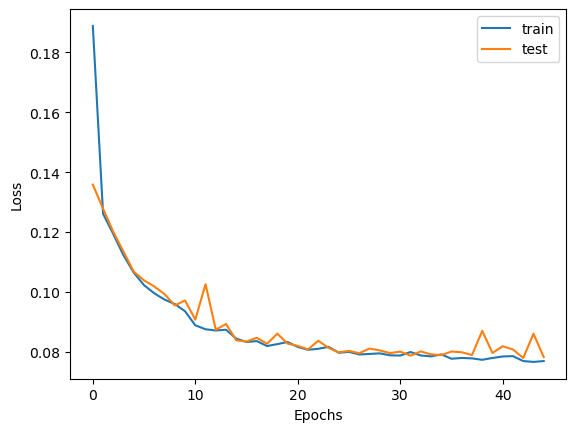

Testing on test dataset: 

38/38 [==============================] - 1s 5ms/step
Test Loss (MSE): 0.07817127638504703
Test MAE: 0.17184249751121636
R^2 Score: 0.45768218220352774


In [187]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Define the model
model = Sequential()
model.add(LSTM(32))
model.add(Dense(1, activation='tanh'))  # Linear activation for regression

# Compile the model
opt = Adam(learning_rate=0.001) 
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mean_absolute_error'])  # Mean Squared Error for regression

# Train the model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=45, batch_size=64, verbose=2)

# Print model summary
print(model.summary())

# Plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model on the test dataset
print("Testing on test dataset: \n")
predictions = model.predict(testX)
loss = mean_squared_error(testy, predictions)
mae = mean_absolute_error(testy, predictions)
r2 = r2_score(testy, predictions)
print(f"Test Loss (MSE): {loss}")
print(f"Test MAE: {mae}")
print(f"R^2 Score: {r2}")


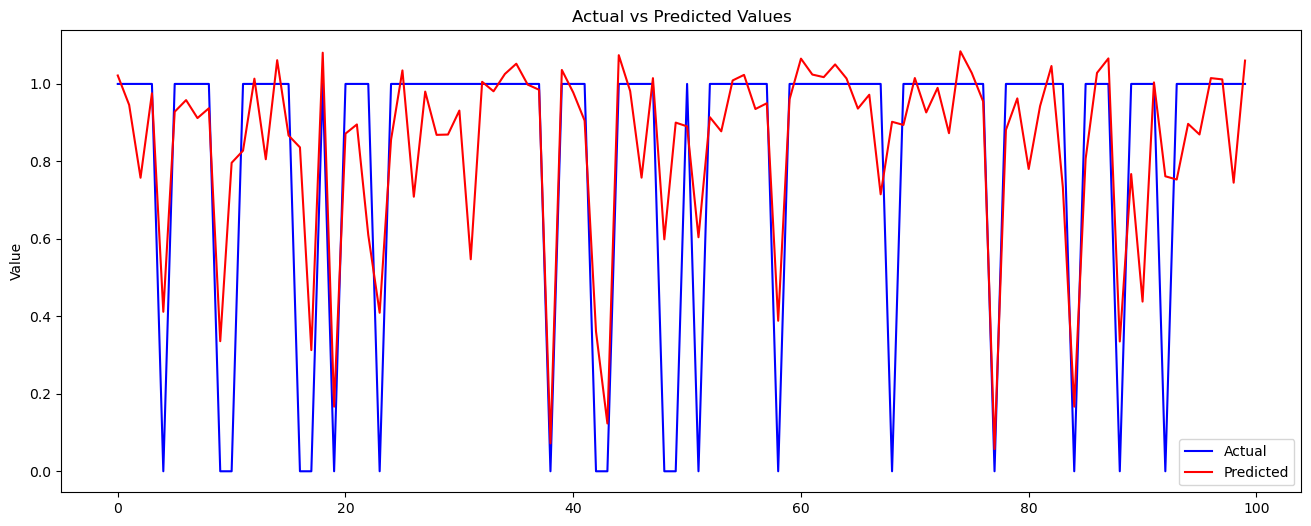

In [186]:
# Plot testy vs predictions
plt.figure(figsize=(16, 6))
plt.plot(testy[:100], label='Actual', color='blue')
plt.plot(predictions[:100], label='Predicted', color='red')
plt.title('Actual vs Predicted Values (Regression)')
plt.ylabel('Value')
plt.legend()
plt.show()


Launch tensorboard to visualise performance

In [172]:
import tensorboard

Plotting ROC curve using different models configurations

Epoch 1/40
133/133 [==============================] - 7s 17ms/step - loss: 0.6871 - accuracy: 0.6670 - val_loss: 0.6799 - val_accuracy: 0.8037
Epoch 2/40
133/133 [==============================] - 1s 7ms/step - loss: 0.6371 - accuracy: 0.7815 - val_loss: 0.5664 - val_accuracy: 0.8212
Epoch 3/40
133/133 [==============================] - 1s 7ms/step - loss: 0.5382 - accuracy: 0.8198 - val_loss: 0.5079 - val_accuracy: 0.8359
Epoch 4/40
133/133 [==============================] - 1s 7ms/step - loss: 0.4778 - accuracy: 0.8158 - val_loss: 0.4403 - val_accuracy: 0.8202
Epoch 5/40
133/133 [==============================] - 1s 7ms/step - loss: 0.4268 - accuracy: 0.8228 - val_loss: 0.4156 - val_accuracy: 0.8212
Epoch 6/40
133/133 [==============================] - 1s 7ms/step - loss: 0.4020 - accuracy: 0.8269 - val_loss: 0.3990 - val_accuracy: 0.8240
Epoch 7/40
133/133 [==============================] - 1s 10ms/step - loss: 0.3933 - accuracy: 0.8285 - val_loss: 0.3927 - val_accuracy: 0.8231
Epoc

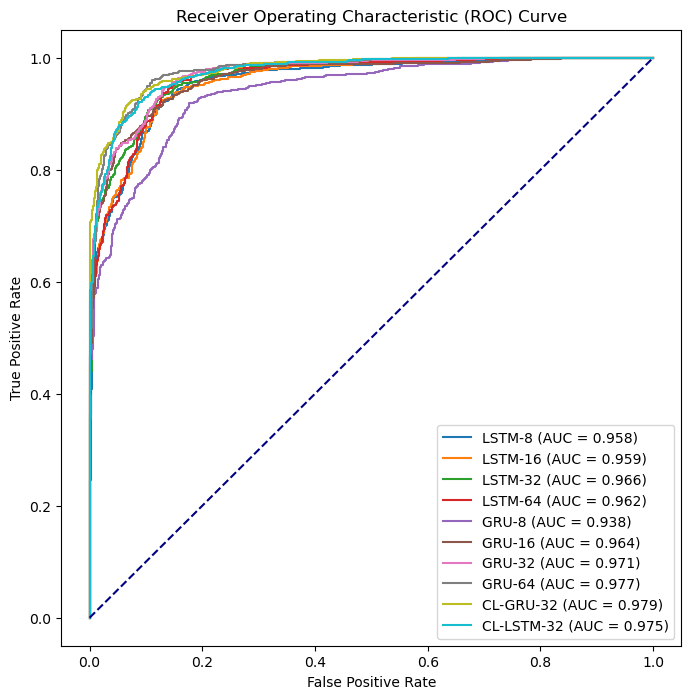

In [14]:
# Define LSTM configurations
neurons_list = [8, 16, 32, 64]

# Create and train models, compute ROC curves, and plot
plt.figure(figsize=(8, 8))
NN = [LSTM, GRU]
for NN_class in NN:
    for neurons in neurons_list:
        # Create and train model
        model = Sequential()
        model.add(NN_class(neurons))
        model.add(Dense(1, activation='sigmoid'))
        opt = Adam(learning_rate=0.001)
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
        model.fit(trainX, trainy, validation_data=(testX, testy), epochs=40, batch_size=64)

        # Make predictions
        y_pred = model.predict(testX)

        # Compute ROC curve
        fpr, tpr, _ = roc_curve(testy, y_pred)
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve
        plt.plot(fpr, tpr, label='{}-{} (AUC = {:.3f})'.format(NN_class.__name__, neurons, roc_auc))

# Reshape data for Conv1D
trainX_conv = trainX.reshape((trainX.shape[0], trainX.shape[1], n_features))




# Define the model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(Tx, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(GRU(32))
model.add(Dense(1, activation='sigmoid'))
# Compile the model
opt = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
# Train the model
model.fit(trainX_conv, trainy, epochs=45, batch_size=64, verbose=2)
# Make predictions
y_pred = model.predict(testX)
# Compute ROC curve
fpr, tpr, _ = roc_curve(testy, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='CL-GRU-32 (AUC = {:.3f})'.format( roc_auc))



# Define the model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(Tx, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(32))
model.add(Dense(1, activation='sigmoid'))
# Compile the model
opt = Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
# Train the model
model.fit(trainX_conv, trainy, epochs=45, batch_size=64, verbose=2)
y_pred = model.predict(testX)
# Compute ROC curve
fpr, tpr, _ = roc_curve(testy, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='CL-LSTM-32 (AUC = {:.3f})'.format(roc_auc))


plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()